# Untersuchung von XAI Methoden

Hier wird untersucht was Ergebnisse der XAI Methoden mit dem Alexnet sind. Für XAI gibt es eine gute Library namens Captum. Captum bietet eine vielzahl von Methoden an.

## 0. Model und Libraries laden


In [4]:
import torch
import torch.nn.functional as F
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from torchvision import transforms
import pandas as pd
from random import randint
from PIL import Image, ImageOps
import os
import scipy
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

from captum.attr import IntegratedGradients,\
    GradientShap,Occlusion,NoiseTunnel,visualization as viz

from monai.networks.nets import DenseNet121
from monai.transforms import (
    NormalizeIntensity,
    EnsureType,
)
import torch

from torchvision.transforms import transforms

torch.manual_seed(0)
np.random.seed(0)


import warnings
warnings.filterwarnings("ignore")


import os

data_path = "../../../data/xai/ksbl/"

In [7]:
_sample = os.listdir("../../../data/xai/ksbl/occlusion_heat2")[0]
_sample
_im_ = Image.open("../../../data/xai/ksbl/occlusion_heat2/"+_sample)
im_size = _im_.size[0]
im_size

338

In [8]:
ind = []
dfo = pd.DataFrame()
dfo_l = []
for i in os.listdir(data_path+"val"):
    if not os.stat(data_path+"val/"+i).st_size or i[-3:]=="jpg":
        continue
    else :
        ind.append(i)
        im_s = data_path+"val/" + i[:-3] + "jpg"
        im = Image.open(im_s)
        dft = pd.read_table(data_path+"val/"+i, header=None, delimiter=' ',encoding='latin1').iloc[:,1:]
        dft = dft.rename(columns={1: "x", 2: "y",3:"w",4:"h"})
        dft["x"] = dft["x"]*im_size
        dft["y"] = dft["y"]*im_size
        dft["w"] = dft["w"]*im_size
        dft["h"] = dft["h"]*im_size
        dft["cx"] = dft["x"]
        dft["cy"] = dft["y"]
        #edge in left corner
        dft["x"] = dft["x"] - dft["w"]/2
        dft["y"] = dft["y"] - dft["h"]/2
        dft["path"] = i
        dfo_l.append(dft)

dfoo = pd.concat(dfo_l)
dfoo = dfoo.reset_index().iloc[:,1:]
dfoo["path"] = dfoo["path"].str.replace("txt","jpg")
dfoo[["x","y","w","h","cx","cy"]] = dfoo[["x","y","w","h","cx","cy"]].astype(int)


In [9]:
dfoo

,x,y,w,h,cx,cy,path
0,51,89,100,45,102,111,AugFx8_dp.jpg
1,120,93,95,46,167,117,DezFx4_dp.jpg
2,53,136,181,80,144,176,DezFx4_dp.jpg
3,76,92,91,59,122,121,DezFx6_dp.jpg
4,81,132,108,36,135,151,DezFx6_dp.jpg
...,...,...,...,...,...,...,...
177,111,153,94,146,159,226,AprilFx33(dia-metaphysar)_dp.jpg
178,125,292,2,3,126,294,AprilFx33(dia-metaphysar)_dp.jpg
179,127,293,25,28,139,308,AprilFx33(dia-metaphysar)_dp.jpg
180,35,172,151,29,110,187,"JanFx24(SchraubenMCII,III)_dp.jpg"


In [10]:
t = []
for i in range(len(dfoo)):
    #im_   = Image.open("val/"+dfoo["path"][i])
    t_in  = np.ones((im_size,im_size))
    x = dfoo["x"][i]
    y = dfoo["y"][i]
    w = dfoo["w"][i]
    h = dfoo["h"][i]
    t_in[y:y+h,x:x+w]=np.zeros((h,w))
    t.append(t_in)

In [11]:
dfoo["in"]  = t

In [12]:
li = dfoo["path"].unique().tolist()
lis = []
for s in li:
    arr = dfoo[dfoo["path"]==s]["in"].sum()
    arr = arr/len(dfoo[dfoo["path"]==s])
    arr = np.rint(arr)
    lis.append(arr)
df_f = pd.DataFrame({"path":li})
df_f["in"] = lis

<AxesSubplot:>

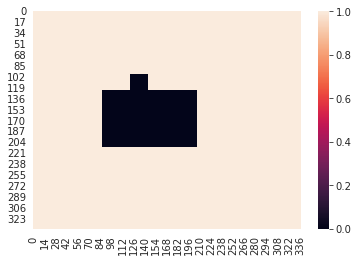

In [13]:
import seaborn as sns
sns.heatmap(df_f["in"][7])

5 verschiedene Modelle laden, mit verschiedenen Initialisierungsseeds

In [8]:
data_path = "../../../data/"
models_path = "model/"
img_path = "data/flattened_flipped_cropped/"
#file deleted; FebFx32_dp.jpg

In [9]:
models_folder = os.listdir(models_path)

In [10]:
model_list = []
for mo in models_folder:
    print(mo)
    model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=2, pretrained=False).to("cpu")
    try:
        model.load_state_dict(torch.load(models_path+ f"{mo}",map_location=torch.device('cpu'))['model_state_dict'])
    except:
        model.load_state_dict(torch.load(models_path+ f"{mo}",map_location=torch.device('cpu')))
    model.eval()
    model_list.append(model)
    del model

DenseNet121_LR0.0019419338184479603_CRFocal Loss_TRAugment_Normalize_OPAdamW_BS10_EP50__ID_fffbf128-4ac7-4582-9e14-b8dd6de281cf_22.pth
DenseNet121_LR0.0019676087078530735_CRFocal Loss_TRAugment_Normalize_OPAdamW_BS12_EP40__ID_02927019-cdb7-4c2e-82c0-4523867cac74.pth


In [12]:
transform2 = transforms.Compose(
        [
            transforms.PILToTensor(),
            NormalizeIntensity(),
            EnsureType(),
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((512, 512))])

## 1.0 Datensatz lesen

In [13]:
# load the image from filtered Dataset
df = pd.read_csv("data/binary_annotations.csv")
sample_0 = df[df['target']==0].sample(1)["filenames"].tolist()[0]
sample_1 = df[df['target']==1].sample(1)["filenames"].tolist()[0]

In [14]:
df

,Unnamed: 0,filenames,target
0,0,3DSchienenGes10_dp.jpg,0
1,1,3DSchienenGes11_dp.jpg,0
2,2,3DSchienenGes12_dp.jpg,0
3,3,3DSchienenGes13_dp.jpg,0
4,4,3DSchienenGes14_dp.jpg,0
...,...,...,...
668,668,SeptFx5_dp.jpg,1
669,669,SeptFx6(SH-Fx)_dp.jpg,1
670,670,SeptFx7_dp.jpg,1
671,671,SeptFx8_dp.jpg,1


### 1.1 transform images

In [15]:
transform = transforms.Compose(
        [
         transforms.Grayscale(num_output_channels=1),
         transforms.Resize(512),
         transforms.ToTensor(),
         ]
    )

transform_normalize = transforms.Normalize(
     mean=0.5,
     std=0.5
 )

In [16]:
def load_image(path,model):
    img = Image.open(img_path + path)
    transformed_img = transform2(img)

    input = transform_normalize(transformed_img)
    input = input.unsqueeze(0)

    output = model(input)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)

    pred_label_idx.squeeze_()
    print("path      = ",path)
    truth_label_idx  =  df[df['filenames']==path]['target'].tolist()[0]
    print("Truth     =",truth_label_idx)
    print('Predicted =', pred_label_idx.item(), '(with score of', prediction_score.squeeze().item(), ')')
    return {"input" :input,
             "output":output,
             "pred_label_idx":pred_label_idx.item(),
             "truth_label_idx":truth_label_idx,
             "transformed_img":transformed_img
             }

Testen von load_image

In [17]:
sample_0_results = load_image(sample_0,model_list[1])

path      =  DezGes61_dp.jpg
Truth     = 0
Predicted = 1 (with score of 0.5686640739440918 )


In [18]:
sample_1_results = load_image(sample_1,model_list[1])

path      =  AprilFx20_dp.jpg
Truth     = 1
Predicted = 1 (with score of 0.5685049891471863 )


## 2.0 Vergleichsmetik

In [20]:
def plot_dist(df,c,h):
    df = pd.DataFrame(df)
    mx = df.max().max()
    mn = df.min().min()
    fig = plt.figure(figsize=(20,4))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i in range(1,len(model_list)+1):
        ax = fig.add_subplot(1, len(model_list), i)
        sns.distplot(df[f"model{i}"],ax=ax,bins=15,color=c)
        ax.set(ylim=(0, h),xlim=(mn,mx))
    plt.show()


In [21]:
def imshow_samples(sample,method):
    plt_in = 161
    for i in range(1,len(model_list)+1):
        igi  = Image.open(data_path + f"xai/ksbl/{method}/heat_map/model{i}/" + sample)
        plt.subplot(plt_in)
        plt.imshow(igi)
        plt.axis('off')
        plt_in+=1
    plt.show()

## 5.0 Occlusion SHAP
   Okklusion ist ein **störungsbasierter Ansatz** zur Berechnung der Attribution, bei dem jede zusammenhängende rechteckige Region durch eine gegebene Basislinie/Referenz ersetzt wird und die Differenz im Output berechnet wird. Bei Merkmalen, die sich in mehreren Regionen (Hyperrechtecken) befinden, werden die entsprechenden Ausgabedifferenzen gemittelt, um die Attribution für das betreffende Merkmal zu berechnen.
   Okklusion ist am nützlichsten in Fällen wie Bildern, wo die Pixel in einer zusammenhängenden rechteckigen Region wahrscheinlich stark korreliert sind.


### 5.1 Laden der Captum Funktion

In [ ]:
def run_occulusion(model,input,pred_label_idx,color,transformed_img,methode = "heat_map"):
    occlusion = Occlusion(model)
    attributions_occ = occlusion.attribute(input,
                                           strides = (32),
                                           target=pred_label_idx,
                                           sliding_window_shapes=(1,60,60),
                                           baselines=0)

    # create custom colormap for visualizing the result
    default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                     [(0, '#ffffff'),
                                                      (1, "red")], N=256)




    p,f = viz.visualize_image_attr_multiple(aaa2,
                                          aaa3,
                                          methods=[methode],
                                          signs=['positive'],
                                          cmap=default_cmap,
                                          show_colorbar=False,
                                          fig_size=(5,5),
                                          alpha_overlay=0.5)
    return p

In [ ]:
_ = run_occulusion(model_list[0],
                        sample_0_results["input"],
                        sample_0_results["pred_label_idx"],
                        colors[0],
                        sample_0_results["transformed_img"],
                        methode="blended_heat_map"
                        )

In [ ]:
#labels = ["Cardiomaly", "Pneomothorax", ]
# load pictures from bbox dataset
def save_all_picutures_occlusion(method):
    for m in range(len(model_list)):
        direcory_xai = f"../../../data/xai/ksbl/occlusion"
        if not os.path.exists(direcory_xai):
            os.makedirs(direcory_xai)
        df_results_all    = df.copy()
        #results_entropy   = []
        results_predicted = []
        for i in df["filenames"].tolist():

            direcory_method = f"{direcory_xai}/{method}"
            if not os.path.exists(direcory_method):
                os.makedirs(direcory_method)

            direcory_model = f"{direcory_method}/model{m+1}"
            if not os.path.exists(direcory_model):
                os.makedirs(direcory_model)

            results = load_image(f"{i}",model_list[m])
            #results_entropy.append(entropy("../../../data/Chest/" + i))
            results_predicted.append(results['pred_label_idx'])

            p = run_occulusion(model=model_list[m],
                                        input=results["input"],
                                        pred_label_idx=results["pred_label_idx"],
                                        color=colors[results["truth_label_idx"]],
                                        transformed_img=results["transformed_img"],
                                        methode = method
                                        )
            p.savefig(f"{direcory_model}/{i}", bbox_inches="tight",pad_inches=0)


        #df_results_all["entropy"]  = results_entropy
        df_results_all["predicted"] = results_predicted
        df_results_all.to_csv(f"../../../data/xai/ksbl/occlusion/heat_map/model{m+1}/results.csv")

### 5.2 Abspeichern der Heatmaps

In [ ]:
%%capture
#save_all_picutures_occlusion(method="heat_map")

In [ ]:
%%capture
#save_all_picutures_occlusion(method="blended_heat_map")

<AxesSubplot:>

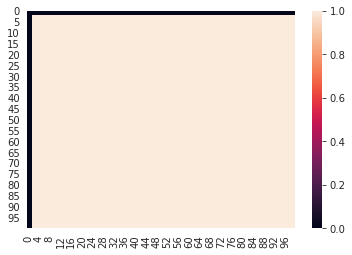

In [14]:
padding = 2


def npPadding(a):
    a[0:padding] = 0
    a[:, 0:padding] = 0
    #a[padding * -1:-1] = 0
    #a[-1] = 0
    #a[:, padding * -1:-1] = 0
    #a[:, -1] = 0
    return a


sns.heatmap(npPadding(np.ones((100, 100))))

In [23]:
clist = os.listdir("../../../data/xai/ksbl/occlusion_heat2")
#clist = list(filter(lambda x: "jpg" in x, clist))

In [25]:
def entropy():
    entropies = []
    for s in clist:
        #hier anpassen !!!
        img = Image.open("../../../data/xai/ksbl/occlusion_heat2/"+ s)
        img = ImageOps.grayscale(img)
        img = ImageOps.invert(img)
        arr = np.asarray(img)
        arr = npPadding(arr)
        # Compute normalized histogram -> p(g)
        p = np.array([(arr == v).sum() for v in range(256)])
        p = p / p.sum()
        # Compute e = -sum(p(g)*log2(p(g)))
        e = -(p[p > 0] * np.log2(p[p > 0])).sum()
        entropies.append(e)
    return entropies

In [26]:
def weighted_dist_from_COM():
    distances_mean = []
    for s in clist:
        #hier anpassen
        img = Image.open("../../../data/xai/ksbl/occlusion_heat2/"+s)
        #img = img.resize((244,244))
        img = ImageOps.grayscale(img)
        img = ImageOps.invert(img)
        arr = np.asarray(img)/255
        arr = npPadding(arr)
        center = scipy.ndimage.center_of_mass(arr)
        distances = []
        for i in range(arr.shape[0]):
            for j in range(arr.shape[1]):
                if arr[i,j]==0.0:
                    continue
                else:
                    a = np.abs(center[0]-i)
                    b = np.abs(center[1]-j)
                    distance = (a+b)**(1/2)
                    weighted_distance = distance * arr[i,j]
                    distances.append(weighted_distance)
        distances_mean.append(sum(distances)/len(distances))
    return distances_mean

In [27]:
occ_results_entropy = entropy()
occ_results = weighted_dist_from_COM()
#plot_dist(occ_results_entropy, "steelblue", 1.5)

In [28]:
from numpy import asarray
from PIL import Image,ImageOps

##TODO
l = os.listdir("../../../data/xai/ksbl/occlusion_heat2")
result_hm_l  = []
result_hm_mo = []
result_hm_mi = []
result_hm_i  = []

result_hm = df_f[["path"]]

for i in l:
    if i.endswith(".csv") or i.endswith(".txt"):
        continue
    else:
        image = Image.open("../../../data/xai/ksbl/occlusion_heat2/"+i)
        image = ImageOps.grayscale(image)
        image = ImageOps.invert(image)
        image = image.resize((im_size,im_size))
        # convert image to numpy array
        data = asarray(image)
        # padding
        data = npPadding(data)
        result_hm_l.append(data)
        result_hm_i.append(i)


result_hm = pd.DataFrame({"path":result_hm_i,"hm":result_hm_l})

In [29]:
results = result_hm.merge(df_f, on="path")
#results = result_bb_center.merge(results, on="path")
results["mask_out"] = results["hm"]*results["in"]
results["mask_in"]  = results["hm"]*(1-results["in"])

<AxesSubplot:>

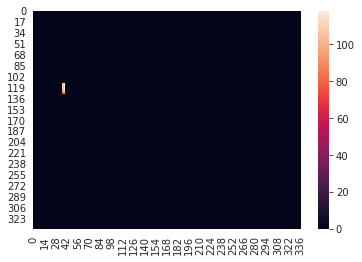

In [30]:
sns.heatmap(results["mask_in"][7])

<AxesSubplot:>

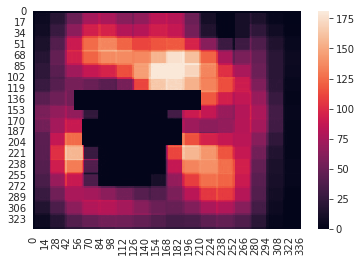

In [31]:
sns.heatmap(results["mask_out"][1])

In [32]:
results

,path,hm,in,mask_out,mask_in
0,AugFx17_dp.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,SeptFx34_dp.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,OktFx17_dp.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,SeptFx31(Wulst-Fx)_dp.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,DezFx6_dp.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...
72,OktFx15_dp.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
73,"JuniFx25(Wulst_Fx,Schiene)_dp.jpg","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
74,JuniFx26_dp.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
75,MaiFx5_dp.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [33]:
# metrik 1
def metrik1(df):
    metrik1_l = []
    for i in range(len(df)):
        metrik1_l.append(np.sum(df["mask_in"][i]) / (np.sum(df["mask_in"][i])+ np.sum(df["mask_out"][i])) * 100)
    return metrik1_l

In [34]:
results2 = dfoo[["cx","cy","path"]].merge(results,on="path")

In [35]:
df_f["path"]

0                         AugFx8_dp.jpg
1                         DezFx4_dp.jpg
2                         DezFx6_dp.jpg
3                         FebFx1_dp.jpg
4                         FebFx3_dp.jpg
                    ...                
77           AprilFx39(Wulst_Fx)_dp.jpg
78        JanFx29(Vakuumschiene)_dp.jpg
79     AprilFx33(dia-metaphysar)_dp.jpg
80    JanFx24(SchraubenMCII,III)_dp.jpg
81    JuniFx25(Wulst_Fx,Schiene)_dp.jpg
Name: path, Length: 82, dtype: object

In [36]:
result_hm["path"]

0              MaiFx25_dp.jpg
1              AugFx17_dp.jpg
2              OktFx35_dp.jpg
3              AugFx23_dp.jpg
4         MaiFx6(Impl)_dp.jpg
                ...          
235    3DSchienenGes38_dp.jpg
236             MaiFx5_dp.jpg
237            NovGes5_dp.jpg
238           SeptFx26_dp.jpg
239           DezGes35_dp.jpg
Name: path, Length: 240, dtype: object

In [50]:
h = os.listdir(data_path+"val")
len(list(set(h) & set(os.listdir("../../../data/xai/ksbl/occlusion_heat2"))))

130

In [38]:
occ_m1 = metrik1(results)

In [41]:
from scipy import ndimage

In [42]:
# metrik 2
def metrik2(df):
    metrik2_l = []
    for l in df["path"].unique().tolist():
        _df = df[df["path"]==l]
        _df = _df.reset_index().iloc[:,1:]
        count = 0
        for i in range(len(_df)):
            center_hm = ndimage.measurements.center_of_mass(_df["hm"][i])
            d_x = center_hm[0]-_df["cx"][i]
            d_y = center_hm[1]-_df["cy"][i]
            count+=(d_x**2+d_y**2)**(1/2)
        metrik2_l.append(count/len(_df))
    return metrik2_l

In [43]:
occ_m2 = metrik2(results2)

In [44]:
df_ksbl_st = pd.DataFrame({"entropy":occ_results_entropy,
                           "DOM": occ_results,
})
df_ksbl_bb = pd.DataFrame({"PgB" : occ_m1,
                           "wDCOM" : occ_m2

})

In [45]:
results2["path"].unique().tolist()

['AugFx8_dp.jpg',
 'DezFx4_dp.jpg',
 'DezFx6_dp.jpg',
 'FebFx1_dp.jpg',
 'FebFx3_dp.jpg',
 'FebFx7_dp.jpg',
 'JanFx5_dp.jpg',
 'MaiFx1_dp.jpg',
 'MaiFx5_dp.jpg',
 'MaiFx8_dp.jpg',
 'OktFx6_dp.jpg',
 'OktFx8_dp.jpg',
 'AugFx14_dp.jpg',
 'AugFx17_dp.jpg',
 'AugFx19_dp.jpg',
 'AugFx21_dp.jpg',
 'AugFx27_dp.jpg',
 'AugFx34_dp.jpg',
 'FebFx11_dp.jpg',
 'FebFx19_dp.jpg',
 'FebFx22_dp.jpg',
 'FebFx26_dp.jpg',
 'JanFx12_dp.jpg',
 'JanFx16_dp.jpg',
 'JanFx19_dp.jpg',
 'JanFx23_dp.jpg',
 'JanFx30_dp.jpg',
 'JanFx31_dp.jpg',
 'JanFx33_dp.jpg',
 'JanFx39_dp.jpg',
 'JanFx41_dp.jpg',
 'JuliFx8_dp.jpg',
 'JuniFx1_dp.jpg',
 'JuniFx4_dp.jpg',
 'MaiFx29_dp.jpg',
 'MaiFx40_dp.jpg',
 'NovFx12_dp.jpg',
 'OktFx15_dp.jpg',
 'OktFx17_dp.jpg',
 'OktFx22_dp.jpg',
 'OktFx30_dp.jpg',
 'SeptFx7_dp.jpg',
 'AprilFx2_dp.jpg',
 'AprilFx5_dp.jpg',
 'JuliFx20_dp.jpg',
 'JuliFx22_dp.jpg',
 'JuliFx23_dp.jpg',
 'JuniFx26_dp.jpg',
 'JuniFx29_dp.jpg',
 'JuniFx31_dp.jpg',
 'SeptFx11_dp.jpg',
 'SeptFx19_dp.jpg',
 'SeptFx25_dp.

<AxesSubplot:xlabel='entropy', ylabel='Density'>

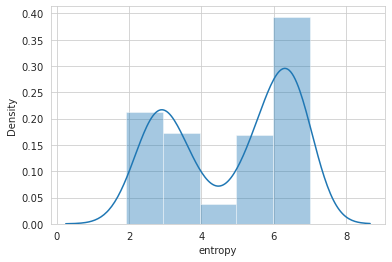

In [46]:
sns.distplot(df_ksbl_st["entropy"])

<AxesSubplot:xlabel='DOM', ylabel='Density'>

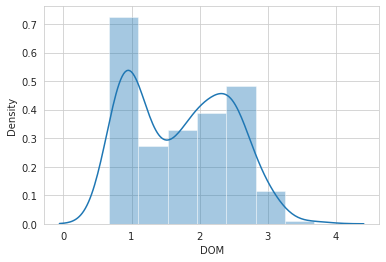

In [47]:
sns.distplot(df_ksbl_st["DOM"])

(0.0, 56.330386868448876)

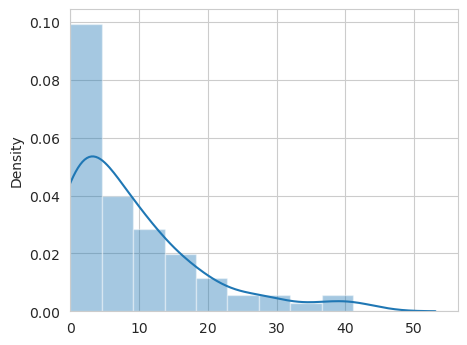

In [53]:
fig, g = plt.subplots(figsize = (5,4), dpi = 100)
g = sns.distplot(occ_m1)
g.set_xlim(left=0)
#g.set_ylim(bottom=0, top=200);

(0.0, 198.56224118358764)

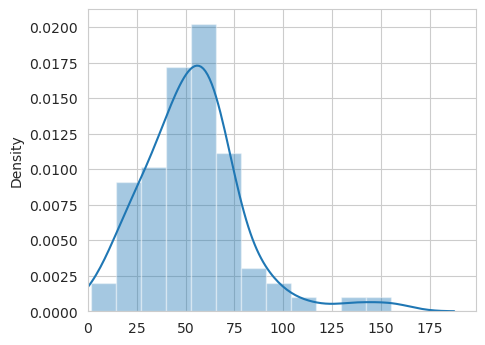

In [54]:
fig, g = plt.subplots(figsize = (5,4), dpi = 100)
g = sns.distplot(occ_m2)
g.set_xlim(left=0)

## 7.0 Save Results

In [ ]:
os.makedirs("results",exist_ok=False)

In [ ]:
os.makedirs("results/ig",exist_ok=False)

In [23]:
df_ksbl_st.to_csv("results/allresults_st.csv")
df_ksbl_bb.to_csv("results/allresults_bb.csv")

NameError: name 'df_ksbl_st' is not defined

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().